In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from adjustText import adjust_text
from numpy import pi, e
from numpy.linalg import inv, det
from numpy.linalg import norm as LA_norm
from numpy.random import random
from scipy.stats import norm
from sklearn.datasets import make_spd_matrix
from termcolor import colored
import itertools
from itertools import combinations, product

In [2]:
def create_matrix(m, n):
    return np.random.rand(m, n)

def initial_inputs(flag):
    if flag == 0:
        # Create initial encoder inputs (B, Sigma_W)
        B = create_matrix(m, n)
        Sigma_W = make_spd_matrix(m)
        return np.concatenate(([flag], B.reshape((m*n)), Sigma_W.reshape((m*m))))
    else:
        # Create initial decoder inputs (A, Sigma_Z)
        A = create_matrix(n, m)
        Sigma_Z = np.diag(random(n))
        return np.concatenate(([flag], A.reshape((n*m)), Sigma_Z.reshape((n*n))))

def is_close_to_zero(arr, etol):
    return np.allclose(arr, 0, atol=etol)

def generate_independent_vectors(n, s):
    identity_matrix = np.identity(n)
    selected_indices = np.random.choice(n, s, replace=False)
    independent_vectors = identity_matrix[:, selected_indices]
    return independent_vectors

def is_singular(matrix):
    is_singular = np.linalg.matrix_rank(matrix) < min(matrix.shape)
    if is_singular:
        print(colored('The matrix is singular.', 'red', attrs=['bold']))
    else:
        print(colored('The matrix is not singular.', 'red', attrs=['bold']))

def is_positive_definite(matrix):
    if np.all(np.linalg.eigvals(matrix) > 0):
        print(colored('The matrix is positive definite.', 'red', attrs=['bold']))
    else:
        print(colored('The matrix is not positive definite.', 'red', attrs=['bold']))
        
def compute_I2(det_v1, det_v2, det_x1v1, det_x2v2, det_v1v2):
    I_2 = round(0.5 * (np.log(det_v1/det_x1v1) + np.log(det_v2/det_x2v2) - np.log(det_v1*det_v2/det_v1v2)), 4)
    print(colored(f'\nI_2 = {I_2}', 'blue', attrs=['bold']))
    return I_2

def matrix_B(A, Sigma_Z):
    inv_Sigma_Z_hat = gamma * inv(Sigma_Z) + 2 * lamda * np.identity(n)
    B = inv(np.identity(m) + A.T @ inv_Sigma_Z_hat @ A) @ A.T @ inv_Sigma_Z_hat
    return B

def covariance_matrix_W(A, Sigma_Z):
    inv_Sigma_Z_hat = gamma * inv(Sigma_Z) + 2 * lamda * np.identity(n)
    Sigma_W = inv(np.identity(m) + A.T @ inv_Sigma_Z_hat @ A)
    return Sigma_W

def matrix_A(B, Sigma_W):
    A = inv(inv(Sigma_Y) + B.T @ inv(Sigma_W) @ B) @ B.T @ inv(Sigma_W)
    return A

def covariance_matrix_Z(B, Sigma_W):
    Sigma_Z = inv(inv(Sigma_Y) + B.T @ inv(Sigma_W) @ B)
    diagonalized_Sigma_Z = np.diag(Sigma_Z.diagonal())
    return diagonalized_Sigma_Z

def covariance_matrix_XV(B):
    cov_XV = np.block([[np.identity(m), B @ eigenvectors @ Sigma_V],
                       [(B @ eigenvectors @ Sigma_V).T, Sigma_V]])
    print(colored('\nCovariance matrix of joint distribution (X,V):', 'blue', attrs=['bold']))
    print(np.round(cov_XV, 4))
    return cov_XV

def encoder_mi(B, Sigma_W):
    return 0.5 * np.log(det(B @ Sigma_Y @ B.T + Sigma_W) / det(Sigma_W))

def decoder_mi(A, Sigma_Z):
    return 0.5 * np.log(det(A @ A.T + Sigma_Z) / det(Sigma_Z))

def mi_VX(B, Sigma_W):
    return 0.5 * np.log(det(B @ Sigma_Y @ B.T + Sigma_W) / det(sigma_squared * B @ B.T + Sigma_W))

def reconstruction_error(recon, orig):
    norm_diff = LA_norm(orig - recon, 2)
    orig_norm = LA_norm(orig, 2)
    recon_err = norm_diff / orig_norm
    return recon_err

def objective_function(A, B, Sigma_Z, Sigma_W):
    Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
    
    regularizer = 0.5 * (np.trace(Sigma_X) - np.log(det(Sigma_W)) - m)
    reconstruction = 0.5 * (np.trace(Sigma_X) + \
                            np.trace(A.T @ inv(Sigma_Z) @ Sigma_Y @ B.T) + \
                            np.trace(inv(Sigma_Z) @ A @ B @ Sigma_Y) - \
                            np.trace(inv(Sigma_Z) @ Sigma_Y) - \
                            np.trace((np.identity(m) + A.T @ inv(Sigma_Z) @ A) @ Sigma_X) - \
                            n * np.log(2 * pi) - np.log(det(Sigma_Z)))
    lambda_term = lamda * np.trace((np.identity(n) - A @ B) @ Sigma_Y @ ((np.identity(n) - A @ B).T) + A @ Sigma_W @ A.T)
    
    return regularizer - gamma * reconstruction + lambda_term

In [3]:
def plot_cost_function(cf_arr):
    """
    Plot values of objective function against iterations t
    """
    plt.plot(range(1, len(cf_arr) + 1), cf_arr)
    plt.xlabel('t')
    plt.ylabel('Cost Function', fontsize=10)
    plt.show()

def plot_encoder_mi(en_mi_arr):
    """
    Plot mutual information of encoder against iterations t
    """
    plt.plot(range(1, len(en_mi_arr) + 1), en_mi_arr)
    plt.xlabel('t')
    plt.ylabel('Mutual Information of Encoder', fontsize=10)
    plt.show()

def plot_decoder_mi(de_mi_arr):
    """
    Plot mutual information of decoder against iterations t
    """
    plt.plot(range(1, len(de_mi_arr) + 1), de_mi_arr)
    plt.xlabel('t')
    plt.ylabel('Mutual Information of Decoder', fontsize=10)
    plt.show()

In [4]:
def print_optimal_solution(sol, m):
    A_arr = sol[:n*m] 
    B_arr = sol[n*m:2*n*m]
    Sigma_Z_arr = sol[2*n*m:2*n*m+n*n]
    Sigma_Z = Sigma_Z_arr.reshape((n, n))
    Sigma_W_arr = sol[2*n*m+n*n:2*n*m+n*n+m*m]
    Sigma_W = Sigma_W_arr.reshape((m, m))
    cost_function = sol[2*n*m+n*n+m*m:2*n*m+n*n+m*m+1][0]
    en_mi = sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0]
    de_mi = sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0]
    recon_err = sol[-1]
    len_cf_mi_arr = sol[2*n*m+n*n+m*m+3:2*n*m+n*n+m*m+6]
    Sigma_X = sol[2*n*m+n*n+m*m+6:2*n*m+n*n+2*m*m+6].reshape((m, m))
    Sigma_Y_hat = sol[2*n*m+n*n+2*m*m+6:2*n*m+2*n*n+2*m*m+6].reshape((n, n))
    
    print(colored('Optimal solution:', attrs=['bold']))
    
    if m > 1:
        print('Matrix A:\n{}'.format(np.round(A_arr.reshape((n, m)), 4)))
        print('\nMatrix B:\n{}'.format(np.round(B_arr.reshape((m, n)), 4)))
        print('\nCovariance matrix of Z:\n{}'.format(np.round(Sigma_Z, 4)))
        print('\nCovariance matrix of W:\n{}'.format(np.round(Sigma_W, 4)))
        print('\nMinimum value of the cost function:\n{}'.format(round(cost_function, 4)))
        print('\nMutual information of the encoder:\n{}'.format(round(en_mi, 4)))
        print('\nMutual information of the decoder:\n{}'.format(round(de_mi, 4)))
        print('\nValue of Sigma_X:\n{}'.format(np.round(Sigma_X, 4)))
        print('\nValue of Sigma_Y_hat:\n{}'.format(np.round(Sigma_Y_hat, 4)))
        print('\nReconstruction error:\n{}'.format(round(recon_err, 4)))
    else:
        print('Vector a:\n{}'.format(np.round(A_arr.reshape((n, m)), 4)))
        print('\nVector b:\n{}'.format(np.round(B_arr.reshape((m, n)), 4)[0]))
        print('\nCovariance matrix of Z:\n{}'.format(np.round(Sigma_Z, 4)))
        print('\nVariance of W:\n{}'.format(np.round(Sigma_W, 4)[0][0]))
        print('\nMinimum value of the cost function:\n{}'.format(round(cost_function, 4)))
        print('\nMutual information of the encoder:\n{}'.format(round(en_mi, 4)))
        print('\nMutual information of the decoder:\n{}'.format(round(de_mi, 4)))
        print('\nValue of Sigma_X:\n{}'.format(np.round(Sigma_X, 4)))
        print('\nValue of Sigma_Y_hat:\n{}'.format(np.round(Sigma_Y_hat, 4)))        
        print('\nReconstruction error:\n{}'.format(round(recon_err, 4)))
        
    return len_cf_mi_arr

def print_comprehensive_results(gamma, lamda, flag, m, n, is_arr):
    if flag == 0:
        # Generate random initial encoder inputs (B, Sigma_W)
        B, Sigma_W = initial_inputs(flag)[1:1+m*n].reshape((m, n)), initial_inputs(flag)[1+m*n:1+m*n+m*m].reshape((m, m))
    else:
        # Generate random initial decoder inputs (A, Sigma_Z)
        A, Sigma_Z = initial_inputs(flag)[1:1+n*m].reshape((n, m)), initial_inputs(flag)[1+n*m:1+n*m+n*n].reshape((n, n))
    
    # Print given inputs
    if is_arr == 0:
        if m > 1 and flag == 0:
            print(colored('Given encoder X:', attrs=['bold']))
            print('Initial matrix B:')
            print(np.round(B.reshape((m, n)), 4))
            print('\nInitial covariance matrix of W:')
            print(np.round(Sigma_W, 4))
        elif m == 1 and flag == 0:
            print(colored('Given encoder X:', attrs=['bold']))
            print('Initial vector b:')
            print(np.round(B.reshape((m, n)), 4)[0])
            print('\nInitial variance of W:')
            print(np.round(Sigma_W, 4)[0][0])
        elif m > 1 and flag == 1:
            print(colored('Given decoder Y_hat:', attrs=['bold']))
            print('Initial matrix A:')
            print(np.round(A.reshape((n, m)), 4))
            print('\nInitial covariance matrix of Z:')
            print(np.round(Sigma_Z, 4))
        else:
            print(colored('Given decoder Y_hat:', attrs=['bold']))
            print('Initial vector a:')
            print(np.round(A.reshape((n, m)), 4))
            print('\nInitial covariance matrix of Z:')
            print(np.round(Sigma_Z, 4))    
    
        # Print results
        if flag == 0:
            # Compute optimal solution given encoder inputs
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
    
            # Extract length of arrays for cost function and mutual information of encoder and decoder
            len_all_arrs = print_optimal_solution(opt_sol, m).astype(int)
            len_cf_arr, len_en_mi_arr = len_all_arrs[:2]
            len_cf_en_mi_arr = len_cf_arr + len_en_mi_arr
        
            # Plot values of cost function and mutual information against iterations
            cf_arr = opt_sol[2*n*m+2*n*n+2*m*m+6 : 2*n*m+2*n*n+2*m*m+6+len_cf_arr]
            plot_cost_function(cf_arr)
    
            en_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_arr : 2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr]
            plot_encoder_mi(en_mi_arr)
    
            de_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr:]
            plot_decoder_mi(de_mi_arr)  
        else:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
        
            len_all_arrs = print_optimal_solution(opt_sol, m).astype(int)
            len_cf_arr, len_en_mi_arr = len_all_arrs[:2]
            len_cf_en_mi_arr = len_cf_arr + len_en_mi_arr
        
            cf_arr = opt_sol[2*n*m+2*n*n+2*m*m+6 : 2*n*m+2*n*n+2*m*m+6+len_cf_arr]
            plot_cost_function(cf_arr)
    
            en_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_arr : 2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr]
            plot_encoder_mi(en_mi_arr)
    
            de_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr:]
            plot_decoder_mi(de_mi_arr)
    else:
        if flag == 0:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
            
            en_mi = round(opt_sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0], 4)
            de_mi = round(opt_sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0], 4)
            recon_err = round(opt_sol[-1], 4)
            
            return [recon_err, en_mi, de_mi, opt_sol]
        else:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
            
            en_mi = round(opt_sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0], 4)
            de_mi = round(opt_sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0], 4)
            recon_err = round(opt_sol[-1], 4)
            
            return [recon_err, en_mi, de_mi, opt_sol]

In [5]:
"""

*****************************************************************
**                          ALGORITHM                          **
*****************************************************************
   
Inputs:
- MAX_ITERS: Maximum number of iterations
- n, m: Dimensions of the matrix
- TOL_ERR: Tolerable error
- Sigma_Y: A random nxn positive definite matrix

Algorithm:
1. Initialize flag
    a. If we start with the encoder, set flag = 0.
    b. Otherwise, set flag = 1.
    
2. Generate initial inputs for the iteration step
    a. If flag = 0, then do:
        i. create random initial encoder inputs, including 
            - a random mxn matrix B
            - a random mxm positive definite covariance matrix Sigma_W
        ii. set flag = 1.
    b. If flag = 1, then do:
        i. create random initial decoder inputs, including 
            - a random nxm matrix A
            - a random nxn positive definite covariance matrix Sigma_Z
        ii. set flag = 0.
        
3. Set iteration counter i = 0. 

4. Iterative step
    a. If flag = 0, given the decoder inputs (A, Sigma_Z) at iteration i,
        i. compute the corresponding encoder inputs at iteration i+1:
            B = matrix_B(A, Sigma_Z)
            Sigma_W = covariance_matrix_W(A, Sigma_Z)
        ii. set flag = 1.
        iii. compute the resulting gamma-VAE cost function and mutual information of the encoder.
        iv. check if the cost function is NaN:
            - if it is, conclude that the algorithm fails to converge and skip to step 7.
        v. check for convergence after the second iteration:
            - if converges, conclude that the algorithm converges and skip to step 7.
            - unless, check if the maximum number of iterations has been reached:
                - if it is, conclude that the algorithm failed to converge and skip to step 7.
                - otherwise, move to step 5.
    b. If flag = 1, given the encoder inputs (B, Sigma_W) at iteration i,
        i. compute the corresponding decoder inputs at iteration i:
            A = matrix_A(B, Sigma_W)
            Sigma_Z = covariance_matrix_Z(B, Sigma_W, is_diagonal)
        ii. set flag = 0.
        iii. compute the resulting gamma-VAE cost function, mutual information of the decoder, and reconstruction error.
        iv. check if the cost function is NaN:
            - if it is, conclude that the algorithm fails to converge and skip to step 7.
        v. check for convergence after the second iteration:
            - if converges, conclude that the algorithm converges and skip to step 7.
            - unless, check if the maximum number of iterations has been reached:
                - if it is, conclude that the algorithm failed to converge and skip to step 7.
                - otherwise, move to step 5.
            
5. Increment iteration counter i <- i + 1.

6. If the iteration counter i < MAX_ITERS, then move back to step 4.
    Otherwise, move to step 7.
    
7. Compute the values of Sigma_X and Sigma_Y_hat.
        
8. Display results
    a. display the optimal solution (A, B, Sigma_Z, Sigma_W).
    b. display the corresponding minimum value of gamma-VAE cost function.
    c. display the resulting mutual information of both encoder and decoder.
    d. display the values of Sigma_X and Sigma_Y_hat.
    e. display the value of reconstruction error.
    f. move to step 9.
    
9. Stop.

"""

def rate_distortion(inputs, is_arr):
    flag = inputs[0]
    if flag == 0:
        B = inputs[1:1+m*n].reshape((m, n))
        Sigma_W = inputs[1+m*n:1+m*n+m*m].reshape((m, m))
        flag = 1
        # Array of current encoder inputs (B_t, Sigma_W_t)
        current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
    else:
        A = inputs[1:1+n*m].reshape((n, m))
        Sigma_Z = inputs[1+n*m:1+n*m+n*n].reshape((n, n))
        flag = 0
        # Array of current decoder inputs (A_t, Sigma_Z_t)
        current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
    
    # Cost function and mutual information arrays
    cf_arr = []
    en_mi_arr = []
    de_mi_arr = [] 

    # Iteration step
    try:
        for i in range(0, MAX_ITERS):
            if  flag == 0:
                B = matrix_B(A, Sigma_Z)
                Sigma_W = covariance_matrix_W(A, Sigma_Z)
                flag = 1
                
                # Check if the value of the cost function is not a number
                current_obj = objective_function(A, B, Sigma_Z, Sigma_W)
                if np.isnan(current_obj):
                    if is_arr == 0:
                        print(colored('\nThe algorithm fails to converge after {} iterations due to NaN values.\n'.format(i+1), 'red', attrs=['bold']))
                    break
                    
                cf_arr = np.concatenate((cf_arr, [current_obj]))
                current_en_mi = encoder_mi(B, Sigma_W)
                en_mi_arr = np.concatenate((en_mi_arr, [current_en_mi]))
                
                # For the first iteration, update the current encoder inputs and value of the cost function
                if i == 0:
                    current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
                    previous_obj = current_obj
                # From the second iteration,
                # 1. Compute the Frobenius norm of the difference between
                #    i. B and itself in the previous iteration
                #    ii. Sigma_W and itself in the previous iteration
                # 2. Compute the difference between the cost function and itself in the previous iteration
                # 3. Update the current encoder inputs and value of the cost function
                else:
                    B_diff = B - current_encoder_inputs[:m*n].reshape((m, n))
                    B_norm_diff = LA_norm(B_diff, 'fro')
                    Sigma_W_diff = Sigma_W - current_encoder_inputs[m*n:m*n+m*m].reshape((m, m))
                    Sigma_W_norm_diff = LA_norm(Sigma_W_diff, 'fro')
                    obj_diff = previous_obj - current_obj
                    previous_obj = current_obj
                    current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
                    # Check for convergence
                    if B_norm_diff <= TOL_ERR and Sigma_W_norm_diff <= TOL_ERR and round(obj_diff, 8) == 0 and \
                    is_close_to_zero(recon_err, 1e-6):
                        if is_arr == 0:
                            print(colored('\nThe algorithm converges after {} iterations.\n'.format(i+1), 'blue', attrs=['bold']))
                        break
            else:
                A = matrix_A(B, Sigma_W)
                Sigma_Z = covariance_matrix_Z(B, Sigma_W)
                flag = 0
                
                current_obj = objective_function(A, B, Sigma_Z, Sigma_W)
                if np.isnan(current_obj):
                    if is_arr == 0:
                        print(colored('\nThe algorithm fails to converge after {} iterations due to NaN values.\n'.format(i+1), 'red', attrs=['bold']))
                    break
                    
                cf_arr = np.concatenate((cf_arr, [current_obj]))
                current_de_mi = decoder_mi(A, Sigma_Z)
                de_mi_arr = np.concatenate((de_mi_arr, [current_de_mi]))
                
                Sigma_Y_hat = A @ A.T + Sigma_Z
                recon_err = reconstruction_error(Sigma_Y_hat, Sigma_Y)
                
                # For the first iteration, update the current decoder inputs and value of the cost function
                if i == 0:
                    current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
                    previous_obj = current_obj
                # From the second iteration,
                # 1. Compute the Frobenius norm of the difference between
                #    i. A and itself in the previous iteration
                #    ii. Sigma_Z and itself in the previous iteration
                # 2. Compute the difference between the cost function and itself in the previous iteration
                # 3. Update the current dencoder inputs and value of the cost function                
                else:
                    A_diff = A - current_decoder_inputs[:n*m].reshape((n, m))
                    A_norm_diff = LA_norm(A_diff, 'fro')
                    Sigma_Z_diff = Sigma_Z - current_decoder_inputs[n*m:n*m+n*n].reshape((n, n))
                    Sigma_Z_norm_diff = LA_norm(Sigma_Z_diff, 'fro')
                    obj_diff = previous_obj - current_obj
                    previous_obj = current_obj
                    current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
                    # Check for convergence
                    if A_norm_diff <= TOL_ERR and Sigma_Z_norm_diff <= TOL_ERR and round(obj_diff, 8) == 0 and \
                    is_close_to_zero(recon_err, 1e-6):
                        if is_arr == 0:
                            print(colored('\nThe algorithm converges after {} iterations.\n'.format(i+1), 'blue', attrs=['bold']))
                        break                       

        # Compute Sigma_X and Sigma_Y_hat  
        Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
        Sigma_Y_hat = A @ A.T + Sigma_Z
        
        sol = np.concatenate((A.reshape((n*m)), B.reshape((m*n)),
                              Sigma_Z.reshape((n*n)), Sigma_W.reshape((m*m)),
                              [current_obj], [current_en_mi], [current_de_mi],
                              [len(cf_arr)], [len(en_mi_arr)], [len(de_mi_arr)],
                              Sigma_X.reshape((m*m)), Sigma_Y_hat.reshape((n*n)),
                              cf_arr, en_mi_arr, de_mi_arr, [recon_err]))
          
        if is_arr == 0 and i == MAX_ITERS - 1 and recon_err > MAX_RECON_ERR:
            print(colored('\nMax iterations was reached!', 'red', attrs=['bold']))
            print('There is NO solutions that has reconstruction error statisfying the tolerance error = {}.\n'.format(MAX_RECON_ERR))
            
        return sol
    
    except Exception as e:
        if is_arr == 0:
            print(colored('\nThe algorithm fails to converge after {} iterations due to {}.\n'.format(i+1, e), 'red', attrs=['bold']))
         
        Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
        Sigma_Y_hat = A @ A.T + Sigma_Z
        
        sol = np.concatenate((A.reshape((n*m)), B.reshape((m*n)),
                              Sigma_Z.reshape((n*n)), Sigma_W.reshape((m*m)),
                              [current_obj], [current_en_mi], [current_de_mi], 
                              [len(cf_arr)], [len(en_mi_arr)], [len(de_mi_arr)],
                              Sigma_X.reshape((m*m)), Sigma_Y_hat.reshape((n*n)),
                              cf_arr, en_mi_arr, de_mi_arr, [recon_err]))
        return sol

## I. Inputs

In [6]:
"""
Given:
1. Maximum number of iterations: MAX_ITERS = 10,000
2. Dimensions of the matrix: s = 4, n = 4, and m = 2
3. Tolerable error: TOL_ERR = 1e-8
4. Reconstruction error tolerance: MAX_RECON_ERR = 0.05
5. A nxn positive definite matrix Sigma_Y = Gamma * Sigma_V * Gamma_T + Sigma_Z_tilde, where:
    - The generative variable V=[v_1,v_2,v_3,v_4] follows a multivariate normal distribution N(0,Sigma_V)
    - v_2 = alpha * v_1 + z_2 and v_4 = beta * v_3 + z_4, 
        where alpha and beta are given scaling factors, and
              z_2 and z_4 are Gaussian noise of N(0, 0.01) and N(0, 0.04), respectively
6. An array of gamma = [0.98, 1.02] with step size = 0.01
7. An array of lambda = [-0.02, 0.02] with step size = 0.01
"""

MAX_ITERS = 10000
s, n, m = 4, 4, 2
TOL_ERR = 1e-8
MAX_RECON_ERR = 0.05

# Generate random values for generative parameters v_1 and v_3
num_samples = int(1e7)
mean = 0
std_dev = 0.05
random_numbers = np.random.normal(mean, std_dev, size=(num_samples, 4))
v_1, v_3 = random_numbers[:, 0], random_numbers[:, 1]

# Calculate additional generative parameters using scaling factors
alpha = 2
beta = 4
std_dev_z2 = 0.02
std_dev_z4 = 0.03
random_noise_z2 = np.random.normal(mean, std_dev_z2, num_samples)
random_noise_z4 = np.random.normal(mean, std_dev_z4, num_samples)
v_2 = alpha * v_1 + random_noise_z2
v_4 = beta * v_3 + random_noise_z4

# Create generative variable V
V = np.array([v_1, v_2, v_3, v_4])

# Compute covariance matrix of V 
Sigma_V = np.round(np.cov(V), 4)
print(f'Given (alpha,beta) = {alpha,beta}:')
print(colored('Covariance matrix of generative variable V:', 'blue', attrs=['bold']))
print(Sigma_V)
is_singular(Sigma_V)

# Independent eigenvectors
eigenvectors = generate_independent_vectors(n, s)
print(colored('\nIndependent eigenvectors:', 'blue', attrs=['bold']))
print(eigenvectors)

# Covariance of noise Z_tilde
sigma_squared = 0.04**2
Sigma_Z_tilde = sigma_squared * np.identity(n)
print(colored('\nCovariance of noise Z_tilde:', 'blue', attrs=['bold']))
print(np.round(Sigma_Z_tilde, 4))

# Positive definite matrix Sigma_Y 
Sigma_Y = eigenvectors @ Sigma_V @ eigenvectors.T + Sigma_Z_tilde
print(colored('\nCovariance matrix of input data Y:', 'blue', attrs=['bold']))
print(np.round(Sigma_Y, 4))
is_positive_definite(Sigma_Y)

gamma_arr = np.round(np.arange(0.98, 1.02, 0.01), 2)
print(colored('\nAn array of gamma:', 'blue', attrs=['bold']))
print('{}'.format(gamma_arr))

lambda_arr = np.round(np.arange(-0.02, 0.03, 0.01), 2)
print(colored('\nAn array of lambda:', 'blue', attrs=['bold']))
print('{}'.format(lambda_arr))

Given (alpha,beta) = (2, 4):
Covariance matrix of generative variable V:
[[0.0025 0.005  0.     0.    ]
 [0.005  0.0104 0.     0.    ]
 [0.     0.     0.0025 0.01  ]
 [0.     0.     0.01   0.0409]]
The matrix is not singular.

Independent eigenvectors:
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]

Covariance of noise Z_tilde:
[[0.0016 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0016]]

Covariance matrix of input data Y:
[[0.0041 0.     0.     0.005 ]
 [0.     0.0041 0.01   0.    ]
 [0.     0.01   0.0425 0.    ]
 [0.005  0.     0.     0.012 ]]
The matrix is positive definite.

An array of gamma:
[0.98 0.99 1.   1.01 1.02]

An array of lambda:
[-0.02 -0.01  0.    0.01  0.02]


## II. Partitioning

In [7]:
print(colored('All ways to divide the indices of the generative parameters into two distinct groups:\n', attrs=['bold']))        

V_indices = np.arange(m+1, m+s+1)

groups_list_V = []
group_1_list_V = []
group_2_list_V = []
group_1_list_XV = []
group_2_list_XV = []

# Initialize an empty list to store valid partitions
valid_partitions = []

# Generate all possible ways to divide the set into 2 groups
for i in range(1, len(V_indices)):
    group_1_combinations = combinations(V_indices, i)
    for group_1 in group_1_combinations:
        group_2 = tuple(index for index in V_indices if index not in group_1)
        valid_partitions.append((set(group_1), set(group_2)))
        
# Print the valid partitions
for idx, partition in enumerate(valid_partitions, start=1):
    group_1, group_2 = partition
    print(f'Partition {idx}: Group 1: {group_1}, Group 2: {group_2}')

    groups_list_V.append([e-1 for e in list(group_1)] + [e-1 for e in list(group_2)])
    group_1_list_V.append(list(group_1))
    group_2_list_V.append(list(group_2))
    group_1_list_XV.append([1] + list(group_1))
    group_2_list_XV.append([2] + list(group_2))

All ways to divide the indices of the generative parameters into two distinct groups:

Partition 1: Group 1: {3}, Group 2: {4, 5, 6}
Partition 2: Group 1: {4}, Group 2: {3, 5, 6}
Partition 3: Group 1: {5}, Group 2: {3, 4, 6}
Partition 4: Group 1: {6}, Group 2: {3, 4, 5}
Partition 5: Group 1: {3, 4}, Group 2: {5, 6}
Partition 6: Group 1: {3, 5}, Group 2: {4, 6}
Partition 7: Group 1: {3, 6}, Group 2: {4, 5}
Partition 8: Group 1: {4, 5}, Group 2: {3, 6}
Partition 9: Group 1: {4, 6}, Group 2: {3, 5}
Partition 10: Group 1: {5, 6}, Group 2: {3, 4}
Partition 11: Group 1: {3, 4, 5}, Group 2: {6}
Partition 12: Group 1: {3, 4, 6}, Group 2: {5}
Partition 13: Group 1: {3, 5, 6}, Group 2: {4}
Partition 14: Group 1: {4, 5, 6}, Group 2: {3}


In [8]:
def max_I2(cov_XV):
    print(colored('\nAll ways to extract elements from the covariance matrix of joint distribution (X,V):', 'red', attrs=['bold']))    

    max_MI = -1000
    max_idx = 0
    
    I2_arr = []
    det_x1v1_arr = []
    det_x2v2_arr = []

    # Generate an array of indices
    for i, (group_1_idx_V, group_2_idx_V,
            group_1_idx_XV, group_2_idx_XV,
            groups_idx_V) in enumerate(zip(group_1_list_V, group_2_list_V,
                                           group_1_list_XV, group_2_list_XV,
                                           groups_list_V)):
        
        # Generate two-digit numbers with repetition from the array and in increasing order
        group_1_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_1_idx_V, repeat=2)]
        group_2_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_2_idx_V, repeat=2)]
        group_1_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_1_idx_XV, repeat=2)]
        group_2_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_2_idx_XV, repeat=2)]
        groups_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(groups_idx_V, repeat=2)]

        print(colored(f'\nPartition {i+1}:', attrs=['bold']))
    
        # Specify the positions to extract
        tuple_list_1_V = [(number // 10 - 1, number % 10 - 1) for number in group_1_two_digit_numbers_V]
        tuple_list_2_V = [(number // 10 - 1, number % 10 - 1) for number in group_2_two_digit_numbers_V]
        tuple_list_1_XV = [(number // 10 - 1, number % 10 - 1) for number in group_1_two_digit_numbers_XV]
        tuple_list_2_XV = [(number // 10 - 1, number % 10 - 1) for number in group_2_two_digit_numbers_XV]
        tuple_list_V = [(int(str(number)[0]), int(str(number)[1])) for number in groups_two_digit_numbers_V]
    
        # Get the new matrix from specified positions
        dim_v1 = len(group_1_idx_V)
        dim_v2 = len(group_2_idx_V)
        dim_x1v1 = len(group_1_idx_XV)
        dim_x2v2 = len(group_2_idx_XV)
        dim_V = s
    
        cov_v1 = np.array([cov_XV[i, j] for i, j in tuple_list_1_V]).reshape(dim_v1, dim_v1)
        if len(cov_v1) == 1:
            cov_v1 = cov_v1[0]
        cov_v2 = np.array([cov_XV[i, j] for i, j in tuple_list_2_V]).reshape(dim_v2, dim_v2)
        if len(cov_v2) == 1:
            cov_v2 = cov_v2[0]
        
        cov_V = np.array([cov_XV[i, j] for i, j in tuple_list_V]).reshape(dim_V, dim_V)
    
        cov_x1v1 = np.array([cov_XV[i, j] for i, j in tuple_list_1_XV]).reshape(dim_x1v1, dim_x1v1)
        cov_x2v2 = np.array([cov_XV[i, j] for i, j in tuple_list_2_XV]).reshape(dim_x2v2, dim_x2v2)
    
        print('\nCovariance matrix of generative parameters v_s1:')
        print(np.round(cov_v1, 4))
        print('Covariance matrix of generative parameters v_s2:')
        print(np.round(cov_v2, 4))
        print('Covariance matrix of joint distribution (v_s1,v_s2):')
        print(np.round(cov_V, 4))
        print('Covariance matrix of joint distribution (x_1,v_s1):')
        print(np.round(cov_x1v1, 4))
        print('Covariance matrix of joint distribution (x_2,v_s2):')
        print(np.round(cov_x2v2, 4))
    
        # Compute the determinant of each covariance matrix
        det_v1v2 = det(cov_V)
        det_x1v1 = det(cov_x1v1)
        det_x2v2 = det(cov_x2v2)
        
        if len(cov_v1) == 1:
            det_v1 = cov_v1[0]
            det_x1v1_arr.append(det_x1v1) 
        else:    
            det_v1 = det(cov_v1)
        if len(cov_v2) == 1:
            det_v2 = cov_v2[0]
            det_x2v2_arr.append(det_x2v2) 
        else:    
            det_v2 = det(cov_v2)
    
        print(f'\nDeterminant of v_s1: {det_v1}')
        print(f'Determinant of v_s2: {det_v2}')
        print(f'Determinant of (v_s1,v_s2): {det_v1v2}') 
        print(f'Determinant of (x_1,v_s1): {det_x1v1}')
        print(f'Determinant of (x_2,v_s2): {det_x2v2}')
    
        # Compute I_2
        I_2 = compute_I2(det_v1, det_v2, det_x1v1, det_x2v2, det_v1v2)
        I2_arr.append(I_2)
    
        if I_2 > max_MI:
            max_MI = I_2
            max_idx = i+1
            
    print(colored(f'\nThe maximum value of I_2 is {max_MI} at Partition {max_idx}.', 'red', attrs=['bold']))
    
    # Compute metric S_D
    S_D = round(0.5 * (max(det_x1v1_arr) / sum(det_x1v1_arr) + max(det_x2v2_arr) / sum(det_x2v2_arr)), 4)
    print(colored(f'\nThe value of S_D is {S_D}.', 'red', attrs=['bold']))
    
    return I2_arr

In [9]:
def plot_I2_vs_partition(arr_I2_values):
    """
    Plots the value of I_2 over the partition.
    """
    
    x = np.arange(1, len(arr_I2_values) + 1)
    y = arr_I2_values

    # Find the index and value of the maximum I_2
    max_index = np.argmax(y)
    max_value = y[max_index]
    partition_max = max_index + 1

    # Create a scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, c='black', marker='o', s=15)
    plt.scatter(partition_max, max_value, c='red', marker='o', s=15, 
                label=f'Max I_2 = {max_value:.2f} at P{partition_max}')

    plt.xlabel('Partition', fontsize=10)
    plt.ylabel('I_2', fontsize=10)
    
    plt.legend(loc='best', fontsize=10)
    plt.show()

## III. Numerical results


Case 1:

Given (gamma,lambda) = (0.98,-0.02), the reconstruction error = 0.0015 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0538  0.0003]
 [-0.0003  0.0556]
 [-0.0009  0.1786]
 [ 0.0921  0.0004]]

Matrix B:
[[ 7.6807 -0.0377 -0.0115  4.4718]
 [ 0.0372  7.772   2.3741  0.0217]]

Covariance matrix of Z:
[[0.0012 0.     0.     0.    ]
 [0.     0.001  0.     0.    ]
 [0.     0.     0.0106 0.    ]
 [0.     0.     0.     0.0035]]

Covariance matrix of W:
[[1.747e-01 1.000e-04]
 [1.000e-04 1.438e-01]]

Minimum value of the cost function:
-4.2681

Mutual information of the encoder:
1.8422

Mutual information of the decoder:
1.8594

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0041 -0.     -0.      0.005 ]
 [-0.      0.0041  0.0099 -0.    ]
 [-0.      0.0099  0.0425 -0.    ]
 [ 0.005  -0.     -0.      0.012 ]]

Reconstruction error:
0.0015

Mutual information between generative variable and latent var

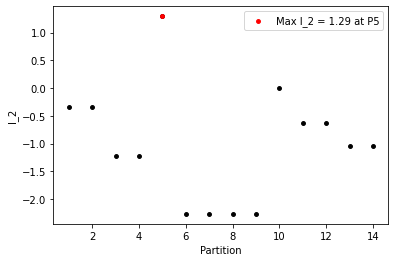


Case 2:

Given (gamma,lambda) = (0.98,-0.01), the reconstruction error = 0.0015 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0398  0.0363]
 [ 0.0374  0.0411]
 [ 0.1203  0.1322]
 [-0.0681  0.062 ]]

Matrix B:
[[-5.6736  5.2112  1.6052 -3.3098]
 [ 5.1662  5.7231  1.7628  3.0138]]

Covariance matrix of Z:
[[0.0012 0.     0.     0.    ]
 [0.     0.001  0.     0.    ]
 [0.     0.     0.0106 0.    ]
 [0.     0.     0.     0.0035]]

Covariance matrix of W:
[[ 0.1606 -0.0154]
 [-0.0154  0.1577]]

Minimum value of the cost function:
-4.2679

Mutual information of the encoder:
1.8424

Mutual information of the decoder:
1.8595

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[0.0041 0.     0.     0.005 ]
 [0.     0.0041 0.0099 0.    ]
 [0.     0.0099 0.0425 0.    ]
 [0.005  0.     0.     0.012 ]]

Reconstruction error:
0.0015

Mutual information between generative variable and latent variable:
1.2962

Covarianc

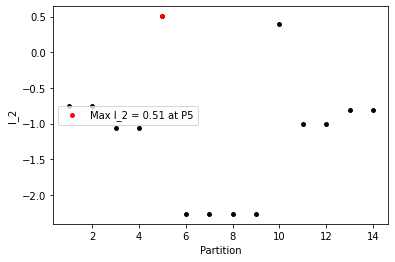


Case 3:

Given (gamma,lambda) = (0.98,0.0), the reconstruction error = 0.0015 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0076  0.0533]
 [ 0.055  -0.0078]
 [ 0.177  -0.0252]
 [ 0.013   0.0912]]

Matrix B:
[[ 1.0821  7.631   2.3702  0.6325]
 [ 7.589  -1.0881 -0.338   4.436 ]]

Covariance matrix of Z:
[[0.0012 0.     0.     0.    ]
 [0.     0.001  0.     0.    ]
 [0.     0.     0.0105 0.    ]
 [0.     0.     0.     0.0035]]

Covariance matrix of W:
[[0.1443 0.0043]
 [0.0043 0.174 ]]

Minimum value of the cost function:
-4.2677

Mutual information of the encoder:
1.8425

Mutual information of the decoder:
1.8596

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0041 -0.     -0.      0.005 ]
 [-0.      0.0041  0.0099 -0.    ]
 [-0.      0.0099  0.0425 -0.    ]
 [ 0.005  -0.     -0.      0.012 ]]

Reconstruction error:
0.0015

Mutual information between generative variable and latent variable:
1.298

Cova

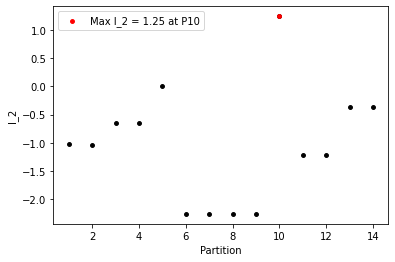


Case 4:

Given (gamma,lambda) = (0.98,0.01), the reconstruction error = 0.0015 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0306  0.0443]
 [-0.0457  0.0316]
 [-0.1472  0.1017]
 [ 0.0524  0.0758]]

Matrix B:
[[ 4.3526 -6.3158 -1.9781  2.5493]
 [ 6.3011  4.3628  1.3664  3.6904]]

Covariance matrix of Z:
[[0.0012 0.     0.     0.    ]
 [0.     0.001  0.     0.    ]
 [0.     0.     0.0105 0.    ]
 [0.     0.     0.     0.0035]]

Covariance matrix of W:
[[0.1537 0.0145]
 [0.0145 0.1646]]

Minimum value of the cost function:
-4.2676

Mutual information of the encoder:
1.8427

Mutual information of the decoder:
1.8597

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0041 -0.     -0.      0.005 ]
 [-0.      0.0041  0.0099 -0.    ]
 [-0.      0.0099  0.0425 -0.    ]
 [ 0.005  -0.     -0.      0.012 ]]

Reconstruction error:
0.0015

Mutual information between generative variable and latent variable:
1.2997

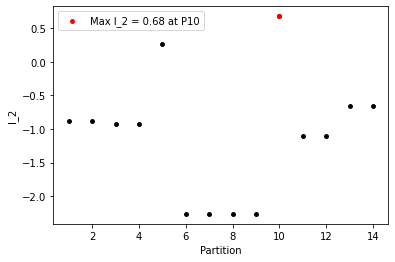


Case 5:

Given (gamma,lambda) = (0.98,0.02), the reconstruction error = 0.0015 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0505 -0.0186]
 [ 0.0192  0.052 ]
 [ 0.062   0.168 ]
 [ 0.0864 -0.0319]]

Matrix B:
[[ 7.1772  2.6474  0.8362  4.2119]
 [-2.6497  7.1709  2.2649 -1.555 ]]

Covariance matrix of Z:
[[0.0012 0.     0.     0.    ]
 [0.     0.001  0.     0.    ]
 [0.     0.     0.0104 0.    ]
 [0.     0.     0.     0.0035]]

Covariance matrix of W:
[[ 0.1709 -0.0101]
 [-0.0101  0.1473]]

Minimum value of the cost function:
-4.2674

Mutual information of the encoder:
1.8429

Mutual information of the decoder:
1.8598

Value of Sigma_X:
[[ 1. -0.]
 [ 0.  1.]]

Value of Sigma_Y_hat:
[[0.0041 0.     0.     0.005 ]
 [0.     0.0041 0.0099 0.    ]
 [0.     0.0099 0.0425 0.    ]
 [0.005  0.     0.     0.012 ]]

Reconstruction error:
0.0015

Mutual information between generative variable and latent variable:
1.3015

Covariance

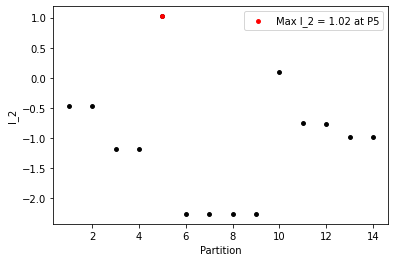


Case 6:

Given (gamma,lambda) = (0.99,-0.02), the reconstruction error = 0.0007 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.054   0.0003]
 [-0.0003  0.0558]
 [-0.0009  0.1787]
 [ 0.0922  0.0005]]

Matrix B:
[[ 7.7121 -0.0411 -0.0123  4.4728]
 [ 0.0404  7.8479  2.3587  0.0234]]

Covariance matrix of Z:
[[0.0012 0.     0.     0.    ]
 [0.     0.001  0.     0.    ]
 [0.     0.     0.0106 0.    ]
 [0.     0.     0.     0.0035]]

Covariance matrix of W:
[[0.1711 0.0002]
 [0.0002 0.1408]]

Minimum value of the cost function:
-4.3305

Mutual information of the encoder:
1.863

Mutual information of the decoder:
1.8716

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[0.0041 0.     0.     0.005 ]
 [0.     0.0041 0.01   0.    ]
 [0.     0.01   0.0425 0.    ]
 [0.005  0.     0.     0.012 ]]

Reconstruction error:
0.0007

Mutual information between generative variable and latent variable:
1.3015

Covariance matrix 

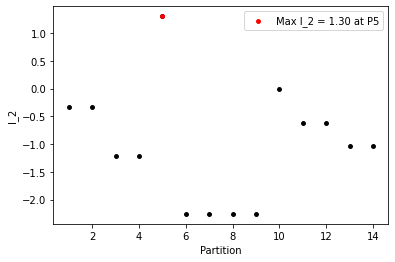


Case 7:

Given (gamma,lambda) = (0.99,-0.01), the reconstruction error = 0.0007 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0536  0.0066]
 [-0.0069  0.0553]
 [-0.022   0.1776]
 [ 0.0916  0.0114]]

Matrix B:
[[ 7.6388 -0.9584 -0.2928  4.4476]
 [ 0.9476  7.7257  2.3603  0.5517]]

Covariance matrix of Z:
[[0.0012 0.     0.     0.    ]
 [0.     0.001  0.     0.    ]
 [0.     0.     0.0105 0.    ]
 [0.     0.     0.     0.0035]]

Covariance matrix of W:
[[0.1706 0.0037]
 [0.0037 0.1412]]

Minimum value of the cost function:
-4.3304

Mutual information of the encoder:
1.863

Mutual information of the decoder:
1.8716

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[0.0041 0.     0.     0.005 ]
 [0.     0.0041 0.01   0.    ]
 [0.     0.01   0.0425 0.    ]
 [0.005  0.     0.     0.012 ]]

Reconstruction error:
0.0007

Mutual information between generative variable and latent variable:
1.3049

Covariance mat

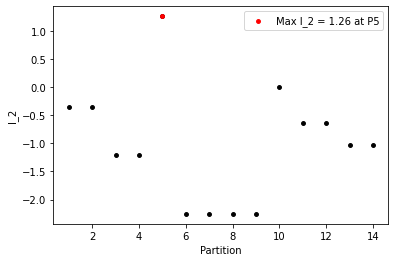


Case 8:

Given (gamma,lambda) = (0.99,0.0), the reconstruction error = 0.0007 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0002  0.0539]
 [ 0.0556  0.0002]
 [ 0.1791  0.0005]
 [-0.0003  0.0923]]

Matrix B:
[[-2.3100e-02  7.7214e+00  2.3982e+00 -1.3500e-02]
 [ 7.6823e+00  2.3300e-02  7.2000e-03  4.4905e+00]]

Covariance matrix of Z:
[[0.0012 0.     0.     0.    ]
 [0.     0.001  0.     0.    ]
 [0.     0.     0.0104 0.    ]
 [0.     0.     0.     0.0035]]

Covariance matrix of W:
[[ 1.408e-01 -1.000e-04]
 [-1.000e-04  1.711e-01]]

Minimum value of the cost function:
-4.3302

Mutual information of the encoder:
1.8632

Mutual information of the decoder:
1.8717

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[0.0041 0.     0.     0.005 ]
 [0.     0.0041 0.01   0.    ]
 [0.     0.01   0.0425 0.    ]
 [0.005  0.     0.     0.012 ]]

Reconstruction error:
0.0007

Mutual information between generative varia

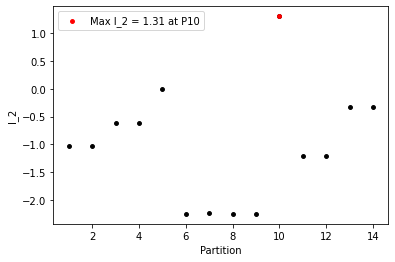


Case 9:

Given (gamma,lambda) = (0.99,0.01), the reconstruction error = 0.0007 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.001   0.0539]
 [ 0.0556 -0.0011]
 [ 0.1793 -0.0034]
 [ 0.0018  0.0923]]

Matrix B:
[[ 0.1459  7.6562  2.4177  0.0856]
 [ 7.6659 -0.1457 -0.046   4.4985]]

Covariance matrix of Z:
[[0.0012 0.     0.     0.    ]
 [0.     0.001  0.     0.    ]
 [0.     0.     0.0103 0.    ]
 [0.     0.     0.     0.0035]]

Covariance matrix of W:
[[0.1407 0.0006]
 [0.0006 0.1711]]

Minimum value of the cost function:
-4.33

Mutual information of the encoder:
1.8634

Mutual information of the decoder:
1.8718

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[0.0041 0.     0.     0.005 ]
 [0.     0.0041 0.01   0.    ]
 [0.     0.01   0.0425 0.    ]
 [0.005  0.     0.     0.012 ]]

Reconstruction error:
0.0007

Mutual information between generative variable and latent variable:
1.3117

Covariance matri

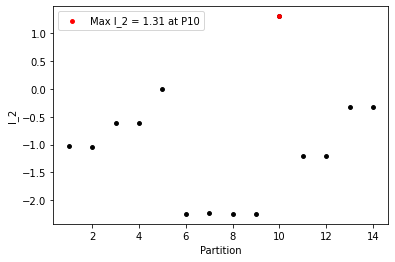


Case 10:

Given (gamma,lambda) = (0.99,0.02), the reconstruction error = 0.0007 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.053   0.0097]
 [-0.01    0.0546]
 [-0.0322  0.1766]
 [ 0.0909  0.0166]]

Matrix B:
[[ 7.5281 -1.362  -0.4373  4.4351]
 [ 1.3726  7.4702  2.3987  0.8086]]

Covariance matrix of Z:
[[0.0012 0.     0.     0.    ]
 [0.     0.001  0.     0.    ]
 [0.     0.     0.0103 0.    ]
 [0.     0.     0.     0.0035]]

Covariance matrix of W:
[[0.1701 0.0054]
 [0.0054 0.1416]]

Minimum value of the cost function:
-4.3299

Mutual information of the encoder:
1.8636

Mutual information of the decoder:
1.872

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0041 -0.      0.      0.005 ]
 [-0.      0.0041  0.01    0.    ]
 [ 0.      0.01    0.0425  0.    ]
 [ 0.005   0.      0.      0.012 ]]

Reconstruction error:
0.0007

Mutual information between generative variable and latent variable:
1.3151

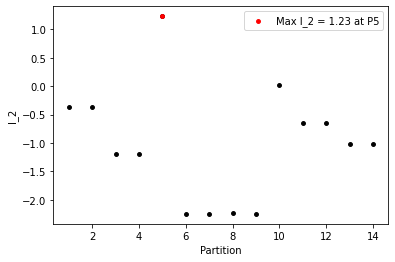


Case 11:

Given (gamma,lambda) = (1.0,-0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.003   0.0558]
 [ 0.0601 -0.0033]
 [ 0.1659 -0.0091]
 [ 0.0049  0.0893]]

Matrix B:
[[ 0.5042 12.0559  1.0668  0.196 ]
 [ 9.2379 -0.658  -0.0582  3.5913]]

Covariance matrix of Z:
[[0.001  0.     0.     0.    ]
 [0.     0.0005 0.     0.    ]
 [0.     0.     0.0149 0.    ]
 [0.     0.     0.     0.004 ]]

Covariance matrix of W:
[[0.096  0.0036]
 [0.0036 0.1609]]

Minimum value of the cost function:
-4.3933

Mutual information of the encoder:
2.0854

Mutual information of the decoder:
2.0855

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0041 -0.     -0.      0.005 ]
 [-0.      0.0041  0.01   -0.    ]
 [-0.      0.01    0.0425 -0.    ]
 [ 0.005  -0.     -0.      0.012 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
1.1247

Cov

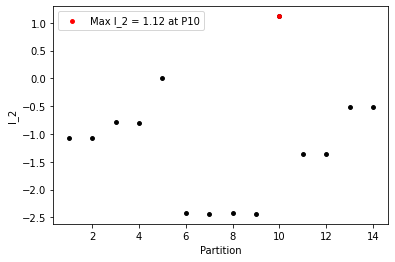


Case 12:

Given (gamma,lambda) = (1.0,-0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0024  0.055 ]
 [ 0.0586  0.0025]
 [ 0.1703  0.0073]
 [-0.0039  0.0907]]

Matrix B:
[[-0.366  10.6011  1.5134 -0.1724]
 [ 8.5205  0.4554  0.065   4.0122]]

Covariance matrix of Z:
[[0.0011 0.     0.     0.    ]
 [0.     0.0007 0.     0.    ]
 [0.     0.     0.0134 0.    ]
 [0.     0.     0.     0.0037]]

Covariance matrix of W:
[[ 0.1195 -0.002 ]
 [-0.002   0.1657]]

Minimum value of the cost function:
-4.3931

Mutual information of the encoder:
1.9612

Mutual information of the decoder:
1.9613

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[0.0041 0.     0.     0.005 ]
 [0.     0.0041 0.01   0.    ]
 [0.     0.01   0.0425 0.    ]
 [0.005  0.     0.     0.012 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
1.1856

Covariance matrix o

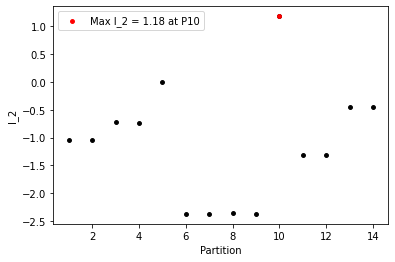


Case 13:

Given (gamma,lambda) = (1.0,0.0), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0458 -0.0288]
 [ 0.0296  0.0472]
 [ 0.0955  0.1519]
 [ 0.0783 -0.0492]]

Matrix B:
[[ 6.5184  4.1145  1.278   3.8101]
 [-4.0955  6.5487  2.034  -2.3939]]

Covariance matrix of Z:
[[0.0012 0.     0.     0.    ]
 [0.     0.001  0.     0.    ]
 [0.     0.     0.0103 0.    ]
 [0.     0.     0.     0.0034]]

Covariance matrix of W:
[[ 0.1592 -0.0134]
 [-0.0134  0.1464]]

Minimum value of the cost function:
-4.3929

Mutual information of the encoder:
1.8834

Mutual information of the decoder:
1.8834

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[0.0041 0.     0.     0.005 ]
 [0.     0.0041 0.01   0.    ]
 [0.     0.01   0.0425 0.    ]
 [0.005  0.     0.     0.012 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
1.3182

Covariance matrix

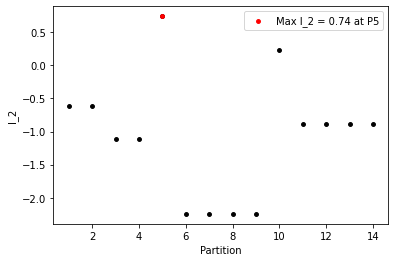


Case 14:

Given (gamma,lambda) = (1.0,0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0106  0.0519]
 [ 0.0516  0.0105]
 [ 0.186   0.038 ]
 [-0.0189  0.0924]]

Matrix B:
[[-1.363   4.4781  3.3238 -1.006 ]
 [ 6.6679  0.9154  0.6794  4.9214]]

Covariance matrix of Z:
[[0.0013 0.     0.     0.    ]
 [0.     0.0013 0.     0.    ]
 [0.     0.     0.0064 0.    ]
 [0.     0.     0.     0.0031]]

Covariance matrix of W:
[[ 0.1171 -0.0099]
 [-0.0099  0.1634]]

Minimum value of the cost function:
-4.3927

Mutual information of the encoder:
1.9805

Mutual information of the decoder:
1.9804

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0041 -0.     -0.      0.005 ]
 [-0.      0.0041  0.01    0.    ]
 [-0.      0.01    0.0425  0.    ]
 [ 0.005   0.      0.      0.012 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
1.5316

Cova

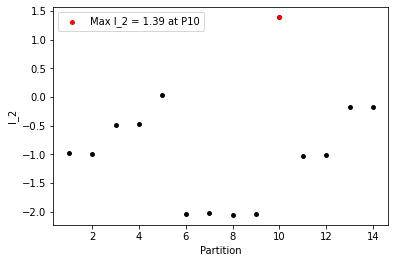


Case 15:

Given (gamma,lambda) = (1.0,0.02), the reconstruction error = 0.0001 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0356  0.0379]
 [ 0.0373  0.035 ]
 [ 0.1425  0.134 ]
 [-0.0659  0.07  ]]

Matrix B:
[[-4.0622  2.1359  2.8497 -3.7954]
 [ 4.3198  2.0085  2.6797  4.0361]]

Covariance matrix of Z:
[[0.0014 0.     0.     0.    ]
 [0.     0.0015 0.     0.    ]
 [0.     0.     0.0043 0.    ]
 [0.     0.     0.     0.0028]]

Covariance matrix of W:
[[ 0.1198 -0.0368]
 [-0.0368  0.1243]]

Minimum value of the cost function:
-4.3927

Mutual information of the encoder:
2.1512

Mutual information of the decoder:
2.1511

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[0.0041 0.     0.     0.005 ]
 [0.     0.0041 0.01   0.    ]
 [0.     0.01   0.0425 0.    ]
 [0.005  0.     0.     0.012 ]]

Reconstruction error:
0.0001

Mutual information between generative variable and latent variable:
1.7115

Covariance mat

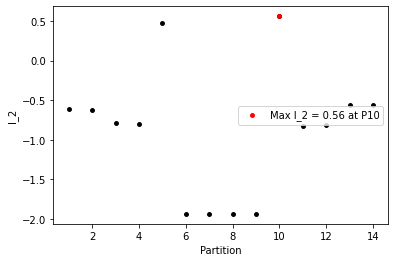


Case 16:

Given (gamma,lambda) = (1.01,-0.02), the reconstruction error = 0.0031 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0052  0.0637]
 [ 0.0637  0.0052]
 [ 0.1553  0.0128]
 [-0.0064  0.0776]]

Matrix B:
[[-1.2866 15.6028  0.     -0.    ]
 [15.6029  1.2866  0.      0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0181 0.    ]
 [0.     0.     0.     0.0059]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
-6.9206

Mutual information of the encoder:
47.3344

Mutual information of the decoder:
47.3195

Value of Sigma_X:
[[ 1.0049 -0.    ]
 [-0.      1.0049]]

Value of Sigma_Y_hat:
[[0.0041 0.     0.     0.005 ]
 [0.     0.0041 0.01   0.    ]
 [0.     0.01   0.0424 0.    ]
 [0.005  0.     0.     0.012 ]]

Reconstruction error:
0.0031

Mutual information between generative variable and latent variable:
0.941

Covaria

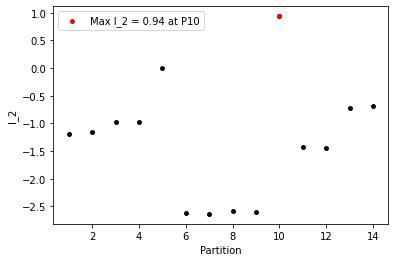


Case 17:

Given (gamma,lambda) = (1.01,-0.01), the reconstruction error = 0.0031 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0638  0.0037]
 [-0.0037  0.0638]
 [-0.009   0.1555]
 [ 0.0778  0.0045]]

Matrix B:
[[15.6296 -0.9067 -0.      0.    ]
 [ 0.9067 15.6295  0.      0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0181 0.    ]
 [0.     0.     0.     0.0059]]

Covariance matrix of W:
[[0. 0.]
 [0. 0.]]

Minimum value of the cost function:
-33102.5942

Mutual information of the encoder:
46.7199

Mutual information of the decoder:
46.7051

Value of Sigma_X:
[[1.0049 0.    ]
 [0.     1.0049]]

Value of Sigma_Y_hat:
[[ 0.0041 -0.     -0.      0.005 ]
 [-0.      0.0041  0.01   -0.    ]
 [-0.      0.01    0.0424 -0.    ]
 [ 0.005  -0.     -0.      0.012 ]]

Reconstruction error:
0.0031

Mutual information between generative variable and latent variable:
0.

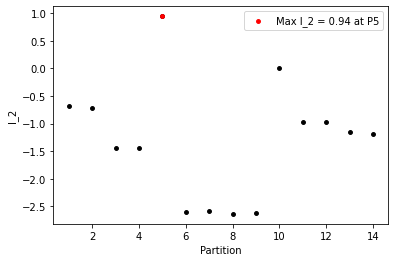


Case 18:

Given (gamma,lambda) = (1.01,0.0), the reconstruction error = 0.0031 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0443 -0.0104]
 [ 0.0145  0.0622]
 [ 0.0354  0.1517]
 [ 0.1064 -0.0249]]

Matrix B:
[[ 0.      3.5605  0.      8.9114]
 [-0.     15.2455  0.     -2.0812]]

Covariance matrix of Z:
[[0.002  0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0181 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
-71.4818

Mutual information of the encoder:
39.5042

Mutual information of the decoder:
39.4894

Value of Sigma_X:
[[ 1.0049 -0.    ]
 [-0.      1.0049]]

Value of Sigma_Y_hat:
[[0.0041 0.     0.     0.005 ]
 [0.     0.0041 0.01   0.    ]
 [0.     0.01   0.0424 0.    ]
 [0.005  0.     0.     0.0119]]

Reconstruction error:
0.0031

Mutual information between generative variable and latent variable:
1.4779

Covaria

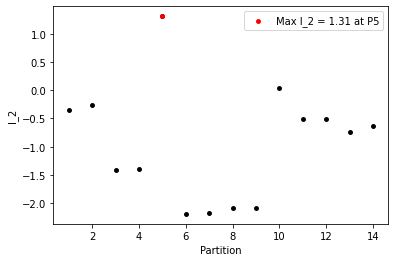


Case 19:

Given (gamma,lambda) = (1.01,0.01), the reconstruction error = 0.0049 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0424  0.0165]
 [-0.0176  0.0451]
 [-0.0747  0.1916]
 [ 0.1018  0.0397]]

Matrix B:
[[ 0.     -0.     -1.7664  8.5261]
 [ 0.      0.      4.5305  3.3242]]

Covariance matrix of Z:
[[0.002  0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[0. 0.]
 [0. 0.]]

Minimum value of the cost function:
-6.9143

Mutual information of the encoder:
46.762

Mutual information of the decoder:
46.7471

Value of Sigma_X:
[[1.0049 0.    ]
 [0.     1.0049]]

Value of Sigma_Y_hat:
[[ 0.0041 -0.     -0.      0.005 ]
 [-0.      0.0041  0.01   -0.    ]
 [-0.      0.01    0.0423 -0.    ]
 [ 0.005  -0.     -0.      0.0119]]

Reconstruction error:
0.0049

Mutual information between generative variable and latent variable:
2.6472



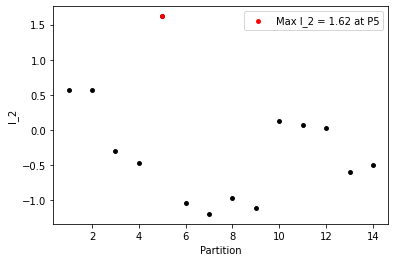


Case 20:

Given (gamma,lambda) = (1.01,0.02), the reconstruction error = 0.0049 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0398  0.0222]
 [ 0.0236  0.0423]
 [ 0.1002  0.1796]
 [-0.0954  0.0532]]

Matrix B:
[[-0.      0.      2.3695 -7.9912]
 [ 0.      0.      4.2462  4.4593]]

Covariance matrix of Z:
[[0.002  0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
66184.4398

Mutual information of the encoder:
47.3582

Mutual information of the decoder:
47.3434

Value of Sigma_X:
[[ 1.0049 -0.    ]
 [-0.      1.0049]]

Value of Sigma_Y_hat:
[[ 0.0041 -0.     -0.      0.005 ]
 [-0.      0.0041  0.01   -0.    ]
 [-0.      0.01    0.0423 -0.    ]
 [ 0.005  -0.     -0.      0.0119]]

Reconstruction error:
0.0049

Mutual information between generative variable and latent variab

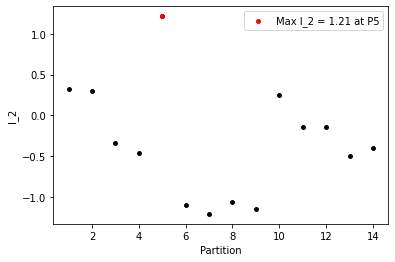


Case 21:

Given (gamma,lambda) = (1.02,-0.02), the reconstruction error = 0.0061 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0632 -0.0085]
 [ 0.0085  0.0632]
 [ 0.0207  0.154 ]
 [ 0.077  -0.0103]]

Matrix B:
[[15.5535  2.0893  0.      0.    ]
 [-2.0894 15.553   0.     -0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0181 0.    ]
 [0.     0.     0.     0.0059]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
7.8918677504443e+25

Mutual information of the encoder:
95.8937

Mutual information of the decoder:
95.8643

Value of Sigma_X:
[[ 1.0097 -0.    ]
 [-0.      1.0097]]

Value of Sigma_Y_hat:
[[0.0041 0.     0.     0.005 ]
 [0.     0.0041 0.0099 0.    ]
 [0.     0.0099 0.0423 0.    ]
 [0.005  0.     0.     0.0119]]

Reconstruction error:
0.0061

Mutual information between generative variable and latent variable:
0.

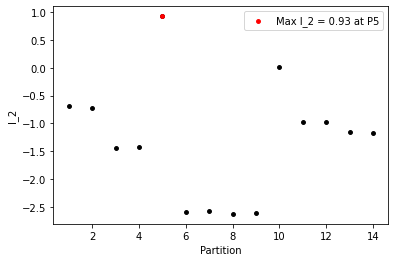


Case 22:

Given (gamma,lambda) = (1.02,-0.01), the reconstruction error = 0.0061 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0024  0.0637]
 [ 0.0637  0.0024]
 [ 0.1553  0.0058]
 [-0.0029  0.0777]]

Matrix B:
[[-0.5839 15.6818  0.     -0.    ]
 [15.6823  0.5838  0.      0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0181 0.    ]
 [0.     0.     0.     0.0059]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
1.1837801625666449e+26

Mutual information of the encoder:
95.208

Mutual information of the decoder:
95.1786

Value of Sigma_X:
[[ 1.0097 -0.    ]
 [-0.      1.0097]]

Value of Sigma_Y_hat:
[[0.0041 0.     0.     0.005 ]
 [0.     0.0041 0.0099 0.    ]
 [0.     0.0099 0.0423 0.    ]
 [0.005  0.     0.     0.0119]]

Reconstruction error:
0.0061

Mutual information between generative variable and latent variable:


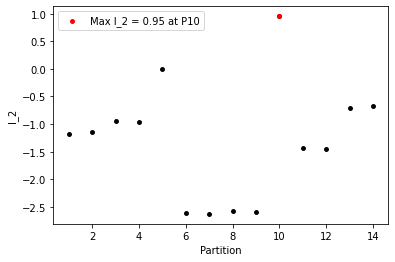


Case 23:

Given (gamma,lambda) = (1.02,0.0), the reconstruction error = 0.0095 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0637  0.0023]
 [ 0.0018  0.0482]
 [ 0.0075  0.205 ]
 [-0.0777  0.0029]]

Matrix B:
[[-15.6826   0.       0.1792  -0.    ]
 [  0.577    0.       4.8708   0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0059]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
3.0827608400173044e+23

Mutual information of the encoder:
89.5331

Mutual information of the decoder:
89.5037

Value of Sigma_X:
[[ 1.0097 -0.    ]
 [-0.      1.0097]]

Value of Sigma_Y_hat:
[[0.0041 0.     0.     0.005 ]
 [0.     0.0041 0.0099 0.    ]
 [0.     0.0099 0.0421 0.    ]
 [0.005  0.     0.     0.0119]]

Reconstruction error:
0.0095

Mutual information between generative variable and latent var

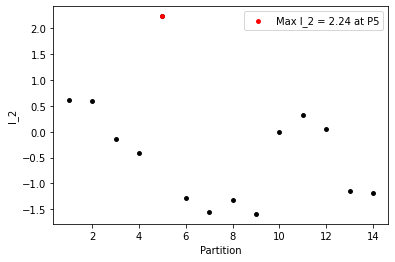


Case 24:

Given (gamma,lambda) = (1.02,0.01), the reconstruction error = 0.0096 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.043   0.0146]
 [ 0.0155  0.0457]
 [ 0.0658  0.1943]
 [-0.1033  0.035 ]]

Matrix B:
[[-0.      0.      1.564  -8.6879]
 [ 0.      0.      4.6164  2.9434]]

Covariance matrix of Z:
[[0.002  0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
3.94593387522215e+25

Mutual information of the encoder:
95.3382

Mutual information of the decoder:
95.3087

Value of Sigma_X:
[[ 1.0097 -0.    ]
 [-0.      1.0097]]

Value of Sigma_Y_hat:
[[ 0.0041 -0.     -0.      0.005 ]
 [-0.      0.0041  0.0099 -0.    ]
 [-0.      0.0099  0.0421 -0.    ]
 [ 0.005  -0.     -0.      0.0119]]

Reconstruction error:
0.0096

Mutual information between generative variable and lat

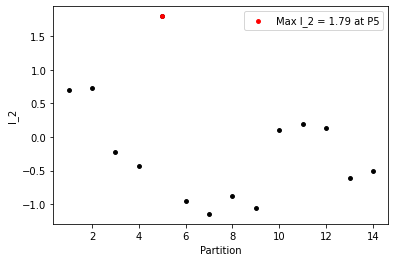


Case 25:

Given (gamma,lambda) = (1.02,0.02), the reconstruction error = 0.0096 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0362  0.0274]
 [ 0.0291  0.0385]
 [ 0.1237  0.1637]
 [-0.087   0.0657]]

Matrix B:
[[-0.      0.      2.9388 -7.3181]
 [ 0.      0.      3.8885  5.5308]]

Covariance matrix of Z:
[[0.002  0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
7.8918677504443e+25

Mutual information of the encoder:
95.9531

Mutual information of the decoder:
95.9236

Value of Sigma_X:
[[ 1.0097 -0.    ]
 [-0.      1.0097]]

Value of Sigma_Y_hat:
[[ 0.0041 -0.     -0.      0.005 ]
 [-0.      0.0041  0.0099 -0.    ]
 [-0.      0.0099  0.0421 -0.    ]
 [ 0.005  -0.     -0.      0.0119]]

Reconstruction error:
0.0096

Mutual information between generative variable and late

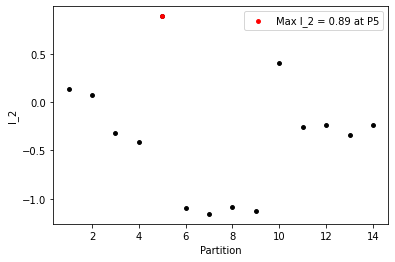

In [10]:
# Constants
MAX_SOLS = 5
is_array = 1
flag = 0
case_num = 1

# Initiate arrays
min_recon_err_arr = []
min_en_mi_arr = []
min_de_mi_arr = []
all_recon_mi_arr = []
satisfied_recon_mi_arr = []
satisfied_gamma_lambda_arr = []

# Iteration step
for i in range(0, len(gamma_arr)):
    gamma = gamma_arr[i]
    for j in range(0, len(lambda_arr)):
        lamda = lambda_arr[j]
        
        min_recon_err, min_en_mi, min_de_mi, min_opt_sol = print_comprehensive_results(gamma, lamda, flag, m, n, is_array)
        
        first_iter = 1
        for num_sols in range(0, MAX_SOLS):
            current_recon_err, current_en_mi, current_de_mi, current_opt_sol = print_comprehensive_results(gamma, lamda, flag, m, n, is_array)
    
            # Check for unique optimal solutions for each (gamma, lambda) pair
            if first_iter == 1:
                if is_close_to_zero(current_opt_sol[:2*n*m+n*n+m*m] - min_opt_sol[:2*n*m+n*n+m*m], 1e-6):
                    is_unique = 1
                    unique_opt_sol = current_opt_sol[:2*n*m+n*n+m*m]
                else:
                    is_unique = 0
                first_iter = 0
            else:
                if is_unique == 1:
                    if is_close_to_zero(current_opt_sol[:2*n*m+n*n+m*m] - unique_opt_sol, 1e-6):
                        unique_opt_sol = current_opt_sol[:2*n*m+n*n+m*m]
                    else:
                        is_unique = 0
    
            # Return the solution with smallest reconstruction error
            if current_recon_err < min_recon_err:
                min_recon_err = current_recon_err
                min_en_mi = current_en_mi
                min_de_mi = current_de_mi
                min_opt_sol = current_opt_sol
                
        min_recon_err_arr = np.concatenate((min_recon_err_arr, [min_recon_err]))
        min_en_mi_arr = np.concatenate((min_en_mi_arr, [min_en_mi]))
        min_de_mi_arr = np.concatenate((min_de_mi_arr, [min_de_mi]))
        all_recon_mi_arr = np.concatenate((all_recon_mi_arr, [min_recon_err, min_en_mi, min_de_mi]))
        
        print(colored('\nCase {}:'.format(case_num), 'blue', attrs=['bold']))
        case_num += 1
        
        if min_recon_err > MAX_RECON_ERR:
            print('\nGiven (gamma,lambda) = ({},{}), the reconstruction error = {} that EXCEEDS the tolerance error = {}.\n'.format(gamma, lamda, min_recon_err, MAX_RECON_ERR))
        else:
            print('\nGiven (gamma,lambda) = ({},{}), the reconstruction error = {} that SATISFIES the tolerance error = {}.\n'.format(gamma, lamda, min_recon_err, MAX_RECON_ERR))
            
            satisfied_gamma_lambda_arr = np.concatenate((satisfied_gamma_lambda_arr, [gamma, lamda]))
            satisfied_recon_mi_arr = np.concatenate((satisfied_recon_mi_arr, [min_recon_err, min_en_mi, min_de_mi]))
        
        if is_unique == 1:
            print(colored('The optimal solution is unique!\n', 'blue', attrs=['bold']))
        else:
            print(colored('The optimal solution is NOT unique!\n', 'red', attrs=['bold']))
        
        print_optimal_solution(min_opt_sol, m)
        
        # Compute mutual information I(V;X) and I_2
        B_opt = min_opt_sol[n*m:2*n*m].reshape((m, n))
        Sigma_W_opt = min_opt_sol[2*n*m+n*n:2*n*m+n*n+m*m].reshape((m, m))
        
        mutual_info_VX = mi_VX(B_opt, Sigma_W_opt)
        print('\nMutual information between generative variable and latent variable:')
        print(round(mutual_info_VX, 4))
        
        cov_XV = covariance_matrix_XV(B_opt)
        I2_arr = max_I2(cov_XV)
        plot_I2_vs_partition(I2_arr)